# Qrylov

## Setup

In [1]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import openfermion as of

In [2]:
def fill_h_and_s_matrices(
    vectors: List[np.ndarray],
    matrix: np.ndarray,
    verbose: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    dim = len(vectors)
    h = np.zeros((dim, dim), dtype=np.complex128)
    s = np.zeros((dim, dim), dtype=np.complex128)

    for i in range(dim):
        for j in range(i, dim):
            if verbose:
                print(i, j)
            hij = vectors[i].conj().T @ matrix @ vectors[j]
            h[i, j] = hij

            if i != j:
                h[j, i] = np.conjugate(hij)

            sij = vectors[i].conj().T @ vectors[j]
            s[i, j] = sij
            if i != j:
                s[j, i] = np.conjugate(sij)
    return h, s


# Based on https://quantum.cloud.ibm.com/docs/en/tutorials/krylov-quantum-diagonalization.
# and Algorithm 1.1 of https://arxiv.org/abs/2110.07492.
def solve_regularized_gen_eig(
    h: np.ndarray,
    s: np.ndarray,
    threshold: float,
) -> float:
    if np.isclose(threshold, 0, atol=1e-10):
        h_reg = h
        s_reg = s
    else:
        s_vals, s_vecs = sp.linalg.eigh(s)
        s_vecs = s_vecs.T
        good_vecs = np.array(
            [vec for val, vec in zip(s_vals, s_vecs) if val > threshold]
        )
        h_reg = good_vecs.conj() @ h @ good_vecs.T
        s_reg = good_vecs.conj() @ s @ good_vecs.T
        return sp.linalg.eigh(h_reg, s_reg)[0][0]

## Problem definition

In [3]:
hamiltonian = of.jordan_wigner(
    of.hamiltonians.fermi_hubbard(
        2,
        2,
        1.0,
        1.0,
    )
)

nqubits = of.utils.count_qubits(hamiltonian)
nqubits

8

In [4]:
hamiltonian_cirq = of.qubit_operator_to_pauli_sum(hamiltonian)
matrix = hamiltonian_cirq.matrix()

In [5]:
assert np.allclose(matrix.conj().T, matrix)

In [6]:
evals_exact, evecs_exact = np.linalg.eigh(matrix)
ground_state = evecs_exact.T[0]
energy_exact = min(evals_exact)
energy_exact

-3.7852608648296595

## Parameters

In [7]:
subspace_dimension: int = 16
threshold: float = 1e-4

In [8]:
bvec = ground_state + np.random.randn(ground_state.shape[0]) / 5.0
bvec /= np.linalg.norm(bvec)

overlap = np.abs(bvec.conj().T @ ground_state) ** 2
overlap

0.09286111147978529

## Krylov with $H$

In [9]:
vectors = [bvec]
for i in range(subspace_dimension - 1):
    vectors.append(
        matrix @ vectors[-1]
    )

In [10]:
h, s = fill_h_and_s_matrices(vectors, matrix)

In [11]:
krylov_evals = []
for d in range(1, len(h) + 1):
    krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
    print(krylov_energy)
    krylov_evals.append(krylov_energy)

0.5192650982699967
-2.061865189228801
-3.112464755331619
-3.5579170310513035
-3.7145393678705974
-3.7526161929888113
-3.7640194708769816
-3.771659019176541
-3.777520528170017
-3.7809754285655797
-3.782853753346339
-3.7838762964713246
-3.784304599347641
-3.7846685850207646
-3.784921094331519
-3.7849834616811977


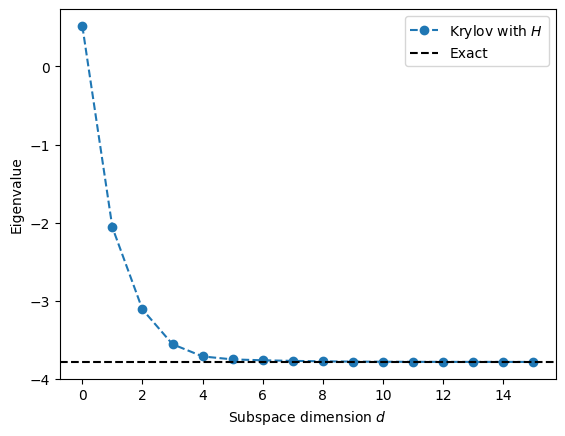

In [12]:
plt.plot(krylov_evals, "--o", label="Krylov with $H$")
plt.axhline(energy_exact, ls="--", color="black", label="Exact")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Eigenvalue")
plt.legend();

### Unitary Krylov

In [13]:
# See Theorem 3.1 of https://arxiv.org/abs/2110.07492.
dt = np.pi / (evals_exact[-1] - evals_exact[0])
dt

0.31172122367084315

In [14]:
vectors_u = []
for k in range(-2 * subspace_dimension, 2 * subspace_dimension + 1, 1):
    print(k)
    Uk = sp.linalg.expm(-1j * matrix * k * dt)
    vectors_u.append(Uk @ bvec)

-32
-31
-30
-29
-28
-27
-26
-25
-24
-23
-22
-21
-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [15]:
h, s = fill_h_and_s_matrices(vectors_u, matrix)

In [16]:
krylov_u_evals = []
for d in range(1, len(h)):
    krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
    print(krylov_energy)
    krylov_u_evals.append(krylov_energy)

0.5192650982699968
-1.8496296087975077
-2.9075186321081476
-3.4309637108479834
-3.665901093768807
-3.7354018500690622
-3.720747337697655
-3.7481553474919753
-3.760202038788944
-3.7547824048008898
-3.765069655827672
-3.760275298860324
-3.768671703851033
-3.77534624547564
-3.7724398520315967
-3.7770627171059736
-3.774342322394345
-3.778999760062591
-3.7765819726814747
-3.7801864684748563
-3.7780219736321325
-3.7813543451369642
-3.7794132279780515
-3.782455386521253
-3.7808932605679764
-3.783296543684835
-3.782378928910544
-3.7835268259848966
-3.7828340208788673
-3.7837253189074054
-3.7831535001668555
-3.7839104713507696
-3.7833841443402862
-3.784103234786184
-3.7836089125406818
-3.7842858312837544
-3.783844861841662
-3.784439829277823
-3.7840384296821945
-3.784570560445366
-3.784200091261716
-3.784703001378446
-3.784351384562809
-3.784854646648994
-3.784529229262143
-3.7850185227850566
-3.784778548691563
-3.7851077822441157
-3.7849383860347414
-3.7851872081392814
-3.785097976110454
-3.78

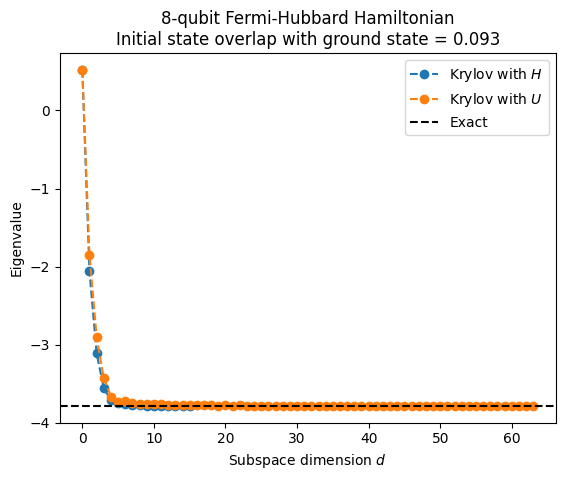

In [17]:
plt.plot(krylov_evals, "--o", label="Krylov with $H$")
plt.plot(krylov_u_evals, "--o", label="Krylov with $U$")
plt.axhline(energy_exact, ls="--", color="black", label="Exact")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Eigenvalue")
plt.title(f"{nqubits}-qubit Fermi-Hubbard Hamiltonian\nInitial state overlap with ground state = {round(overlap, 3)}")
plt.legend();

## Trotterized unitary Krylov

In [41]:
import cirq
from cirq.contrib.qasm_import import circuit_from_qasm

import qiskit
import qiskit.qasm2

In [42]:
def cirq_pauli_sum_to_qiskit_pauli_op(pauli_sum: cirq.PauliSum) -> qiskit.quantum_info.SparsePauliOp:
    """Returns a qiskit.SparsePauliOp representation of the cirq.PauliSum."""
    cirq_pauli_to_str = {cirq.X: "X", cirq.Y: "Y", cirq.Z: "Z"}

    qubits = pauli_sum.qubits
    terms = []
    coeffs = []
    for term in pauli_sum:
        string = ""
        for qubit in qubits:
            if qubit not in term:
                string += "I"
            else:
                string += cirq_pauli_to_str[term[qubit]]
        terms.append(string)
        assert np.isclose(term.coefficient.imag, 0.0, atol=1e-7)
        coeffs.append(term.coefficient.real)
    return qiskit.quantum_info.SparsePauliOp(terms, coeffs)

In [43]:
hamiltonian_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(hamiltonian_cirq)

In [40]:
ntrotter: int = 24

In [44]:
trotter_operation = qiskit.circuit.library.PauliEvolutionGate(
    hamiltonian_qiskit,
    time=dt,
    synthesis=qiskit.synthesis.LieTrotter(reps=ntrotter)
)

trotter_circuit = qiskit.QuantumCircuit.from_instructions(
    [[trotter_operation]],
    qubits=qiskit.QuantumRegister(trotter_operation.num_qubits),
)
trotter_circuit = qiskit.transpile(
    trotter_circuit, basis_gates=["u3", "cx"]
)  # TODO: Compile to a target backend, e.g. IBM Fez.
trotter_circuit.count_ops()

OrderedDict([('cx', 2281), ('u3', 2207)])

In [45]:
qasm = qiskit.qasm2.dumps(trotter_circuit)
trotter_circuit_cirq = circuit_from_qasm(qasm.replace("qregless", "q"))

qubits = sorted(trotter_circuit_cirq.all_qubits())
Utrotter = cirq.unitary(trotter_circuit_cirq)

assert np.allclose(Utrotter.conj().T @ Utrotter, np.identity(Utrotter.shape[0]))

U = sp.linalg.expm(-1j * matrix * dt)
np.abs(np.trace(U.conj().T @ Utrotter)) / 2 ** nqubits

0.999980931939295

In [46]:
vectors_u_trotter = []
for k in range(-2 * subspace_dimension, 2 * subspace_dimension + 1, 1):
    print(k)
    Uk = np.linalg.matrix_power(Utrotter, k)
    vectors_u_trotter.append(Uk @ bvec)

-32
-31
-30
-29
-28
-27
-26
-25
-24
-23
-22
-21
-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [47]:
h, s = fill_h_and_s_matrices(vectors_u_trotter, matrix)

In [48]:
krylov_u_trotter_evals = []
for d in range(1, len(h)):
    krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
    print(krylov_energy)
    krylov_u_trotter_evals.append(krylov_energy)

0.5206402420444379
-1.85015557912867
-2.9083370288907764
-3.431761822674723
-3.6657663371585443
-3.734999764775047
-3.7203408529533544
-3.747864968397494
-3.759918356149423
-3.75458189954917
-3.764781057705859
-3.760027212163224
-3.7683952088984096
-3.775036346273913
-3.7721338377285956
-3.776738264974353
-3.7740259811814116
-3.7787580774102234
-3.776289035982035
-3.7799939881325533
-3.777711240190726
-3.7811516267273286
-3.7790977130996435
-3.7822255236237217
-3.780630510701194
-3.7830720109983598
-3.782152214940995
-3.7833261408603156
-3.7826139388609947
-3.783532429183353
-3.7829205029568493
-3.7837275419483434
-3.783148622666677
-3.7839412114250615
-3.783413484630866
-3.78411107138931
-3.7836692440689284
-3.7842502493114583
-3.78384474442765
-3.7843791982579047
-3.783983341263974
-3.784533686826226
-3.784144451656126
-3.7847045043261422
-3.784350551888437
-3.7848597270078375
-3.78461675600189
-3.784924660462288
-3.7847572786227657
-3.7849988648413766
-3.784898679971785
-3.784713576

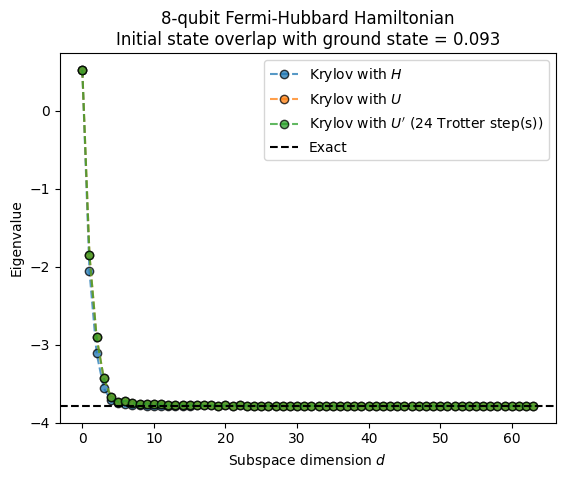

In [49]:
kwargs = {"alpha": 0.75, "mec": "black"}
plt.plot(krylov_evals, "--o", label="Krylov with $H$", **kwargs)
plt.plot(krylov_u_evals, "--o", label="Krylov with $U$", **kwargs)
plt.plot(krylov_u_trotter_evals, "--o", label=rf"Krylov with $U'$ ({ntrotter} Trotter step(s))", **kwargs)
plt.axhline(energy_exact, ls="--", color="black", label="Exact")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Eigenvalue")
plt.title(f"{nqubits}-qubit Fermi-Hubbard Hamiltonian\nInitial state overlap with ground state = {round(overlap, 3)}")
plt.legend();

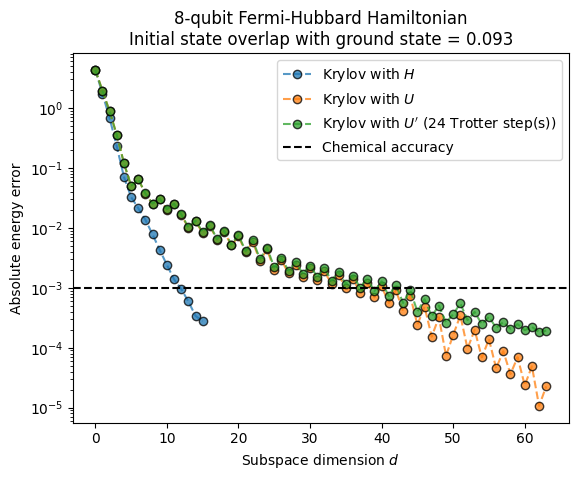

In [51]:
errors_h = np.abs(np.array(krylov_evals) - energy_exact)
errors_u = np.abs(np.array(krylov_u_evals) - energy_exact)
errors_u_trotter = np.abs(np.array(krylov_u_trotter_evals) - energy_exact)

plt.plot(errors_h, "--o", label="Krylov with $H$", **kwargs)
plt.plot(errors_u, "--o", label="Krylov with $U$", **kwargs)
plt.plot(errors_u_trotter, "--o", label=rf"Krylov with $U'$ ({ntrotter} Trotter step(s))", **kwargs)
plt.axhline(1e-3, ls="--", color="black", label="Chemical accuracy")

plt.title(f"{nqubits}-qubit Fermi-Hubbard Hamiltonian\nInitial state overlap with ground state = {round(overlap, 3)}")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Absolute energy error")

plt.yscale("log")
plt.legend();